In [ ]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, Binarizer  # Include Binarizer here
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [ ]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.info()

In [ ]:
# Assuming train_df is your training dataframe and it has already been loaded

# Extract currency units from 'Liabilities' and identify unique units
currency_units = {value.split()[-1] for value in train_df['Liabilities'] if isinstance(value, str)}

# Print the unique currency units
print(currency_units)


In [ ]:
def currency_to_num(currency_series):
    if pd.api.types.is_numeric_dtype(currency_series):
        return currency_series
    return pd.to_numeric(currency_series.str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Preprocess the data
for df in [train_df, test_df]:
    df['Total Assets'] = currency_to_num(df['Total Assets'])
    df['Liabilities'] = currency_to_num(df['Liabilities'])
    df['Assets_to_Liabilities'] = df['Total Assets'] / np.where(df['Liabilities'] == 0, 0.01, df['Liabilities'])

In [ ]:
train_df['Total Assets'].value_counts()

In [ ]:
train_df['Liabilities'].corr(train_df['Criminal Case'])

In [ ]:
train_df['Liabilities'].corr(train_df['Total Assets'])

In [ ]:
train_df['Total Assets'].corr(train_df['Criminal Case'])

In [ ]:
train_df['Criminal Case'].value_counts()

In [ ]:
train_df.head()

In [ ]:
train_df['Party'].value_counts()

In [ ]:
# Encode the 'Education' column
label_encoder = LabelEncoder()
train_df['Education'] = label_encoder.fit_transform(train_df['Education'])


In [ ]:
# Imputation and scaling
numeric_columns = ['Total Assets', 'Liabilities', 'Assets_to_Liabilities']
imputer = SimpleImputer(strategy='mean')
train_df[numeric_columns] = imputer.fit_transform(train_df[numeric_columns])

In [ ]:
train_df = pd.get_dummies(train_df.drop(['ID', 'Candidate', 'Constituency ∇'], axis=1), drop_first=True)

In [ ]:
# Prepare data for modeling
X = train_df.drop('Education', axis=1)
y = train_df['Education']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
model = BernoulliNB()
search_space = {
    'alpha': Real(0.0001, 10, prior='log-uniform'),
    'binarize': Real(0.0, 1.0)  # Optimize threshold for binarizing in the model itself
}

In [ ]:
# Setup Bayesian optimization
opt = BayesSearchCV(model, search_space, n_iter=32, scoring='f1_weighted', cv=StratifiedKFold(5), n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

In [ ]:
# Evaluate the optimized model
y_pred = opt.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Optimized Validation Accuracy: {accuracy}')
print("Optimized F1-Score:", f1)

In [ ]:
# Ensure test_df columns match training features
test_df[numeric_columns] = imputer.transform(test_df[numeric_columns])
test_df = pd.get_dummies(test_df.drop(['Candidate', 'Constituency ∇'], axis=1), drop_first=True)
test_df = test_df.reindex(columns=X_train.columns, fill_value=0)


In [ ]:
# Predict on test data using the optimized binarization threshold
test_predictions = opt.predict(test_df)

In [ ]:
# Create a DataFrame from test_predictions
submission_df = pd.DataFrame({
    'ID': test_df.index,  # If 'ID' column is in test_df, replace 'index' with 'ID'
    'Education': label_encoder.inverse_transform(test_predictions)
})

In [ ]:
# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Submission saved!")


In [ ]:
print(train_df.columns)


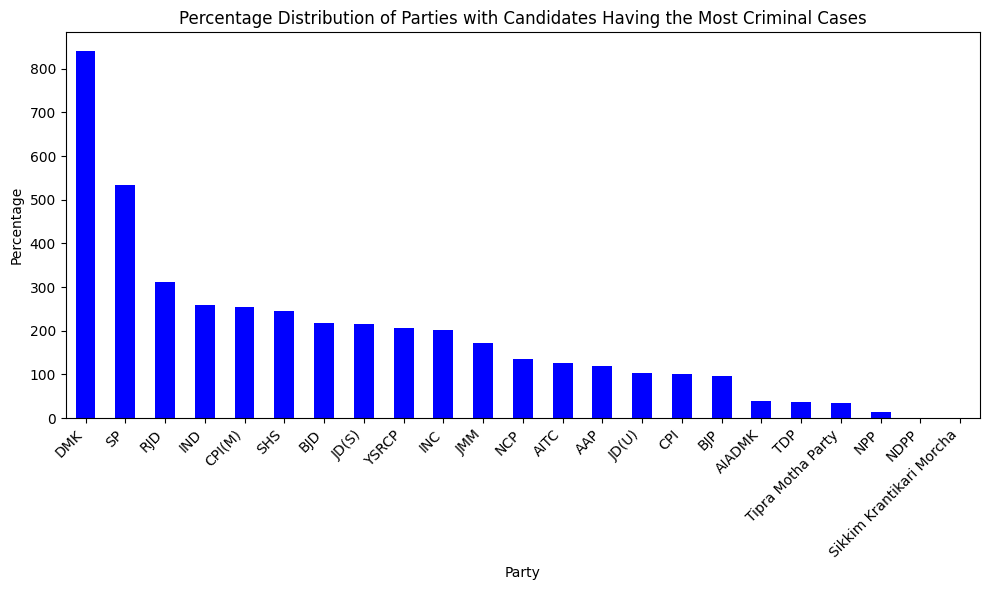

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('train.csv')

# Calculate the percentage distribution of parties with candidates having the most criminal cases
criminal_cases_distribution = train_df.groupby('Party')['Criminal Case'].sum() / train_df.groupby('Party')['Criminal Case'].count() * 100
criminal_cases_distribution = criminal_cases_distribution.sort_values(ascending=False)

# Plot the percentage distribution of parties with candidates having the most criminal cases
plt.figure(figsize=(10, 6))
criminal_cases_distribution.plot(kind='bar', color='blue')
plt.title('Percentage Distribution of Parties with Candidates Having the Most Criminal Cases')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [ ]:
# Check unique values in the 'Total Assets' column
print(train_df['Total Assets'].unique())


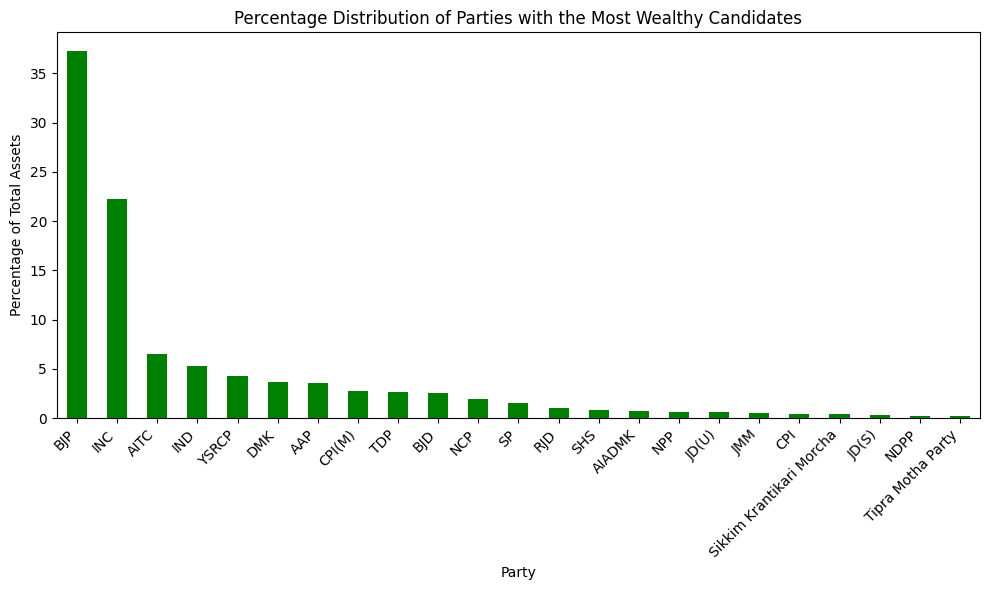

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('train.csv')

# Function to convert currency strings to numeric
def currency_to_num(currency_series):
    return pd.to_numeric(currency_series.str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Preprocess the data
train_df['Total Assets'] = currency_to_num(train_df['Total Assets'])

# Calculate the total assets held by each party
party_assets = train_df.groupby('Party')['Total Assets'].sum()

# Calculate the percentage distribution of parties with the most wealthy candidates
wealthy_candidates_distribution = party_assets / party_assets.sum() * 100
wealthy_candidates_distribution = wealthy_candidates_distribution.sort_values(ascending=False)

# Plot the percentage distribution of parties with the most wealthy candidates
plt.figure(figsize=(10, 6))
wealthy_candidates_distribution.plot(kind='bar', color='green')
plt.title('Percentage Distribution of Parties with the Most Wealthy Candidates')
plt.xlabel('Party')
plt.ylabel('Percentage of Total Assets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
education_distribution = train_df['Education'].value_counts(normalize=True) * 100
education_distribution.plot(kind='bar', color='purple')
plt.title('Distribution of Education Levels among Candidates')
plt.ylabel('Percentage')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example code for a histogram of 'Total Assets'
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Total Assets'], bins=50, kde=True)
plt.title('Distribution of Total Assets')
plt.xlabel('Total Assets')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Example code for a histogram of 'Liabilities'
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Liabilities'], bins=50, kde=True)
plt.title('Distribution of Liabilities')
plt.xlabel('Liabilities')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Example code for a bar plot of 'Education' levels
education_counts = train_df['Education'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=education_counts.index, y=education_counts.values)
plt.title('Counts of Different Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Counts')
plt.show()

In [ ]:
# Example code for a confusion matrix of the model predictions
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()